## Segmentación de organos humanos sobre imagenes de resonancia magnetica mediante redes neuronales profundas.

<img src="https://i.ibb.co/vJTPZgN/banner.jpg">

### Imports:

In [0]:
#imports:
import glob
import cv2 as cv
import os
import sys
import matplotlib.pyplot as plt
from __future__ import print_function
import nibabel as nib
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from skimage.segmentation import mark_boundaries
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from skimage.exposure import rescale_intensity
from keras.callbacks import History
from skimage import io
from data import load_train_data, load_test_data
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
import tensorflow as tf
from tensorflow import keras

In [0]:
!pip install tensorflow

In [1]:
#path ejemplo /content/drive/My Drive/Colab Notebooks/Python/Proyectos/2019-2-vision-por-computadora-proyecto
#path ejemplo /content/drive/My Drive/Colab Notebooks/2019-2-vision-por-computadora-proyecto
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/2019-2-vision-por-computadora-proyecto
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/2019-2-vision-por-computadora-proyecto
/content/drive/My Drive/Colab Notebooks/2019-2-vision-por-computadora-proyecto


### [Ingrese nombre de proyecto]

**Integrantes:**

- Jorge Andres Mogotocoro Fajardo - 2160075
- Mario Hernan Vallejo Huertas    - 2150403
- Bryan Daniel Alvarez            - 

### Objetivo general

- Segmentar el hígado a partir de escaneos de pacientes mediante visión por computadora.

### Objetivos especificos

-  [ - - - ]
-  [ - - - ]
-  [ - - - ]

### Preguntas por responder

- **Problema a resolver:**  
R: Segmentar el hígado a partir de escaneos de pacientes
- **¿Como se va resolver?**  
R: Basandonos en el metodo utilizado en el trabajo de investigacion ["U-Net: Convolutional Networks for Biomedical
Image Segmentation"](https://arxiv.org/pdf/1505.04597.pdf)
- **¿Por qué se necesita resolver este problema?**  
R: El desarrollo tecnológico ha propiciado un cambio asombroso en la medicina, proveyendo de procesos que explican el porqué de muchas enfermedades, de eventos que ocurren en el organismo humano por tanto nuestro proyecto pretende como objetivo a futuro dar a disposicion de la medicina una herramienta que en caso particular permita detectar anomalias en el higado basados en su forma no obstante las bases empleadas esperamos puedan ser de mucha utilidad no solo en detectar un higado si no por el contrario llegar a generalizarse.
- **¿Para que?**  
R: Nuestro proyecto en principio tiene el objetivo de convertirse en una herramienta lo suficientemente precisa para dictaminar desiciones criticas que puedan salvar y/o prevenir la vida de un paciente.
- **¿Para quien(es) seria util esta solucion?**  
R: 

### Documentacion del problema:



- [La importancia de la tecnologia en la medicina](https://prezi.com/wdfcq6jniuaf/la-importancia-de-la-tecnologia-en-la-medicina/)

[Pequeño resumen]

- [Nibabel library](https://nipy.org/nibabel/)

[¿Que es?]

- [U-Net: Convolutional Networks for Biomedical
Image Segmentation](https://prezi.com/wdfcq6jniuaf/la-importancia-de-la-tecnologia-en-la-medicina/)

[Pequeño resumen]

### Implementacion

#### Dataset

[Fuente](https://www.dropbox.com/s/8h2avwtk8cfzl49/ircad-dataset.zip?dl=0)

- El dataset cuenta con formato **nii.gz** (nibabel, [NIfTI](http://niftilib.sourceforge.net/pynifti/intro.html)) el cual hace referencia a datos de neuro imagenes (imagenes de resonancia magnetica estructural MRI). Es un nuevo formato de tados peropuesto por el  [**Grupo de Trabajo de Formato de Datos de NIfTI**](http://nifti.nimh.nih.gov/dfwg/beyond-nifti-1) como una "medida a corto plazo para facilitar la interacción de los paquetes de software de análisis de datos de IRM funcionales.
- Se dispone de 20 conjuntos de imagenes por resonancia magnéticas tomadas a 20 diferentes pacientes.
- Los 20 conjuntos de datos se dividen en 20 imagenes por resonancia magnética identificadas por **orig** y 20 conjunto de imagenes mostrando unicamente la zona donde se ubica el higado en su correspondiente imagen por resonancia magnética original, se identifican por **liver**.
- Cada conjunto de imagenes de resonancia magnetica tomadas para cada paciente tiene dimenciones de **512 de ancho** por **512 de alto** por la cantidad de tomas o **secciones** que fueron capturadas.

##### Exploracion de los datos

In [0]:
def plot_1(imagen):

  plt.axis('off')
  img = plt.imshow(imagen, cmap="gray")
  return img

In [0]:
data_path = 'raw/test/'
example_filename = os.path.join(data_path, 'ircad_e20_orig.nii.gz')
img_orig = nib.load(example_filename)
img_orig.shape

(512, 512, 225)

In [0]:
data_orig = img_orig.get_fdata()

In [0]:
interact(lambda index:plot_1(data_orig[:,:,index]),
         index = widgets.IntSlider(min=0,max=112,
                                   step=1))

interactive(children=(IntSlider(value=0, description='index', max=112), Output()), _dom_classes=('widget-inter…

<function __main__.<lambda>>

In [0]:
data_path = 'raw/test/'
example_filename = os.path.join(data_path, 'ircad_e14_liver.nii.gz')
img_liver = nib.load(example_filename)
img_liver.shape

(512, 512, 113)

In [0]:
data_liver = img.get_fdata()

In [0]:
interact(lambda index:plot_1(data_liver[:,:,index]),
         index = widgets.IntSlider(min=0,max=112,
                                   step=1))

interactive(children=(IntSlider(value=0, description='index', max=112), Output()), _dom_classes=('widget-inter…

<function __main__.<lambda>>

#### Video ilustrativo

In [0]:
def image_to_frames(image, i):
    if i < 10:
        f_name = "frames/frame000"+str(i)+".png"
    else:
        if i < 100:
            f_name = "frames/frame00"+str(i)+".png"
        else:
            f_name = "frames/frame0"+str(i)+".png"    
    cv.imwrite(f_name, image)

def frame_to_video(nombre_video):
    img_array = []
    for filename in glob.glob('frames/frame*.png'):
        img = cv.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
 
    out = cv.VideoWriter(nombre_video,cv.VideoWriter_fourcc(*'DIVX'), 15, size)
    
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [0]:
!mkdir frames
for i in range(data_orig.shape[2]):
  image = data_orig[:,:,i]
  image_to_frames(image, i)

frame_to_video("data_orig.avi")

In [0]:
def image_to_frames_2(image, i):
    if i < 10:
        f_name = "frames/frame000"+str(i)+".png"
    else:
        if i < 100:
            f_name = "frames/frame00"+str(i)+".png"
        else:
            f_name = "frames/frame0"+str(i)+".png"

    plt.axis('off')
    plt.imshow(image, 'gray')    
    plt.savefig(f_name, dpi=300, bbox_inches='tight')

!mkdir frames
for i in tqdm( range(data_liver.shape[2]) ):
  image = data_liver[:,:,i]
  image_to_frames_2(image, i)

frame_to_video("data_liver.avi")

<img src="https://s5.gifyu.com/images/data_orig_2.gif">

#### Particion de los datos

In [0]:
def load_image(path, image):
  example_filename = os.path.join(path, image)
  img_orig = nib.load(example_filename)
  data_orig = img_orig.get_fdata()
  return data_orig

In [0]:
def plot_2(imagenes):
  interact(lambda index:plot_1(imagenes[:,:,index]),
         index = widgets.IntSlider(min=0,max=112,
                                   step=1))

**Datos de Entrenamineto**

In [0]:
data_path = 'raw/'
train_data_path = os.path.join(data_path, 'train')
images_train_path = os.listdir(train_data_path)
images_train_path.sort()

In [174]:
training_images = images_train_path[1::2] 
training_images

['ircad_e01_orig.nii.gz',
 'ircad_e02_orig.nii.gz',
 'ircad_e03_orig.nii.gz',
 'ircad_e04_orig.nii.gz',
 'ircad_e05_orig.nii.gz',
 'ircad_e06_orig.nii.gz',
 'ircad_e07_orig.nii.gz',
 'ircad_e08_orig.nii.gz',
 'ircad_e09_orig.nii.gz',
 'ircad_e10_orig.nii.gz',
 'ircad_e11_orig.nii.gz',
 'ircad_e12_orig.nii.gz',
 'ircad_e13_orig.nii.gz']

In [175]:
training_masks = images_train_path[::2]
training_masks

['ircad_e01_liver.nii.gz',
 'ircad_e02_liver.nii.gz',
 'ircad_e03_liver.nii.gz',
 'ircad_e04_liver.nii.gz',
 'ircad_e05_liver.nii.gz',
 'ircad_e06_liver.nii.gz',
 'ircad_e07_liver.nii.gz',
 'ircad_e08_liver.nii.gz',
 'ircad_e09_liver.nii.gz',
 'ircad_e10_liver.nii.gz',
 'ircad_e11_liver.nii.gz',
 'ircad_e12_liver.nii.gz',
 'ircad_e13_liver.nii.gz']

In [176]:
imgs_train = [] 
masks_train = [] 

training_images = images_train_path[1::2] 
training_masks = images_train_path[::2]

image_rows = int(512/2)
image_cols = int(512/2) 

for liver, orig in zip(training_masks, training_images):

  training_image = load_image(train_data_path,orig)
  training_mask = load_image(train_data_path,liver)

  for k in range(training_image.shape[2]):

    image_2d = np.array(training_image[::2, ::2, k])
    mask_2d = np.array(training_mask[::2, ::2, k]) 

    if len(np.unique(mask_2d)) != 1:
      imgs_train.append(image_2d)
      masks_train.append(mask_2d)

    print("Cargando datos de entrenamineto ...")
    print(liver)
    print(orig)
    print(k,"/",training_image.shape[2])
    clear_output()
  
                
imgs = np.ndarray(
        (len(imgs_train), image_rows, image_cols), dtype=np.uint8
        )
imgs_mask = np.ndarray(
        (len(masks_train), image_rows, image_cols), dtype=np.uint8
        )

for index, img in enumerate(imgs_train):
    imgs[index, :, :] = img
    
for index, img in enumerate(masks_train):
    imgs_mask[index, :, :] = img

x_train = imgs
y_train = imgs_mask

print(x_train.shape)
print(y_train.shape)

(1444, 256, 256)
(1444, 256, 256)


>**Notas**

**Añadir la dimencion para keras**


In [177]:
x_train = np.expand_dims(x_train, axis=3)
y_train = np.expand_dims(y_train, axis=3)
print(x_train.shape)
print(y_train.shape)

(1444, 256, 256, 1)
(1444, 256, 256, 1)


**Test**

In [0]:
data_path = 'raw/'
test_data_path = os.path.join(data_path, 'test')
images_test_path = os.listdir(test_data_path)
images_test_path.sort()

In [179]:
testing_images = images_test_path[1::2] 
testing_images

['ircad_e14_orig.nii.gz',
 'ircad_e15_orig.nii.gz',
 'ircad_e16_orig.nii.gz',
 'ircad_e17_orig.nii.gz',
 'ircad_e18_orig.nii.gz',
 'ircad_e19_orig.nii.gz',
 'ircad_e20_orig.nii.gz']

In [180]:
testing_masks = images_test_path[::2]
testing_masks

['ircad_e14_liver.nii.gz',
 'ircad_e15_liver.nii.gz',
 'ircad_e16_liver.nii.gz',
 'ircad_e17_liver.nii.gz',
 'ircad_e18_liver.nii.gz',
 'ircad_e19_liver.nii.gz',
 'ircad_e20_liver.nii.gz']

In [181]:
imgs_test = [] 
masks_test = [] 

testing_images = images_test_path[1::2] 
testing_masks = images_test_path[::2]

image_rows = int(512/2)
image_cols = int(512/2) 

for liver, orig in zip(testing_masks, testing_images):

  testing_image = load_image(test_data_path,orig)
  testing_mask = load_image(test_data_path,liver)

  for k in range(testing_mask.shape[2]):

    image_2d = np.array(testing_image[::2, ::2, k])
    mask_2d = np.array(testing_mask[::2, ::2, k]) 

    imgs_test.append(image_2d)
    masks_test.append(mask_2d)

    print("Cargando datos de test ...")
    print(liver)
    print(orig)
    print(k,"/",testing_image.shape[2])
    clear_output()
  
                
imgs = np.ndarray(
        (len(imgs_test), image_rows, image_cols), dtype=np.uint8
        )
imgs_mask = np.ndarray(
        (len(masks_test), image_rows, image_cols), dtype=np.uint8
        )

for index, img in enumerate(imgs_test):
    imgs[index, :, :] = img
    
for index, img in enumerate(masks_test):
    imgs_mask[index, :, :] = img

x_test = imgs
y_test = imgs_mask

print(x_test.shape)
print(y_test.shape)

(935, 256, 256)
(935, 256, 256)


**Añadir la dimencion para keras**


In [182]:
x_test = np.expand_dims(x_test, axis=3)
y_test = np.expand_dims(y_test, axis=3)

print(x_test.shape)
print(y_test.shape)

(935, 256, 256, 1)
(935, 256, 256, 1)


#### Normalizacion de los datos

In [0]:
x_train = x_train.astype('float32')

mean = np.mean(x_train) 
std = np.std(x_train)  

x_train -= mean
x_train /= std

x_test = x_test.astype('float32')
x_test -= mean
x_test /= std

#### Modelos

##### CNN

**Supuesto:** A partir del conjunto de datos **liver** en un primer momento se pretende reducir la informacion de imagenes binarias que indica por cada pixel si se encuentra el higado presente a etiquetas,donde por cada conjunto de datos de pacientes para una imagen de resonancia magnetica asignar una etiqueta de si se encuentra o no el higado presente en toda la imagen.

In [0]:
data_path = 'raw/test/'
example_filename = os.path.join(data_path, 'ircad_e20_liver.nii.gz')
img_orig = nib.load(example_filename)
img_orig.shape

(512, 512, 225)

In [0]:
data_liver = img_orig.get_fdata()
data_liver[:,:,125].mean()

0.0

##### U-Net

**Metricas**

In [0]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

**Modelo UNET**

In [190]:
img_rows = int(512/2)
img_cols = int(512/2)

inputs = keras.Input((img_rows, img_cols, 1))
conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = keras.layers.concatenate([keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = keras.layers.concatenate([keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = keras.layers.concatenate([keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = keras.layers.concatenate([keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model_unet = keras.Model(inputs=[inputs], outputs=[conv10])

model_unet.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])

model_unet.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_247 (Conv2D)             (None, 256, 256, 32) 320         input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_248 (Conv2D)             (None, 256, 256, 32) 9248        conv2d_247[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_52 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_248[0][0]                 
___________________________________________________________________________________________

In [191]:
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
print('-'*30)
print('Fitting model...')
print('-'*30)
history=model_unet.fit(x_train, y_train, batch_size=10, epochs=20, verbose=1, shuffle=True,
          validation_split=0.2,
          validation_data=(x_test, y_test),
          callbacks=[model_checkpoint])

------------------------------
Fitting model...
------------------------------
Train on 1444 samples, validate on 935 samples
Epoch 1/20
1444/1444 [==============================] - 32s 22ms/sample - loss: -0.6656 - dice_coef: 0.6661 - val_loss: -0.5541 - val_dice_coef: 0.5539
Epoch 2/20
1444/1444 [==============================] - 19s 13ms/sample - loss: -0.8646 - dice_coef: 0.8645 - val_loss: -0.5682 - val_dice_coef: 0.5666
Epoch 3/20
1444/1444 [==============================] - 19s 13ms/sample - loss: -0.8910 - dice_coef: 0.8911 - val_loss: -0.6274 - val_dice_coef: 0.6264
Epoch 4/20
1444/1444 [==============================] - 19s 13ms/sample - loss: -0.9157 - dice_coef: 0.9157 - val_loss: -0.6612 - val_dice_coef: 0.6616
Epoch 5/20
1444/1444 [==============================] - 19s 13ms/sample - loss: -0.9370 - dice_coef: 0.9371 - val_loss: -0.6636 - val_dice_coef: 0.6652
Epoch 6/20
1444/1444 [==============================] - 18s 12ms/sample - loss: -0.9483 - dice_coef: 0.9483 - val_

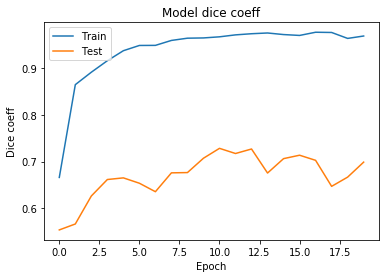

In [192]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Exploracion por capas**

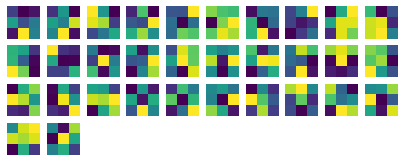

In [216]:
w = model_unet.get_weights()[0]
plt.figure(figsize=(7,7))
w = (w-np.min(w))/(np.max(w)-np.min(w))
for i in range(w.shape[-1]):
    plt.subplot(10,10,i+1)
    plt.imshow(w[:,:,0,i])
    plt.axis("off")

In [218]:
layer_outputs = [layer.output for layer in model_unet.layers ]
layer_outputs

[<tf.Tensor 'input_14:0' shape=(?, 256, 256, 1) dtype=float32>,
 <tf.Tensor 'conv2d_247/Relu:0' shape=(?, 256, 256, 32) dtype=float32>,
 <tf.Tensor 'conv2d_248/Relu:0' shape=(?, 256, 256, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d_52/MaxPool:0' shape=(?, 128, 128, 32) dtype=float32>,
 <tf.Tensor 'conv2d_249/Relu:0' shape=(?, 128, 128, 64) dtype=float32>,
 <tf.Tensor 'conv2d_250/Relu:0' shape=(?, 128, 128, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_53/MaxPool:0' shape=(?, 64, 64, 64) dtype=float32>,
 <tf.Tensor 'conv2d_251/Relu:0' shape=(?, 64, 64, 128) dtype=float32>,
 <tf.Tensor 'conv2d_252/Relu:0' shape=(?, 64, 64, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_54/MaxPool:0' shape=(?, 32, 32, 128) dtype=float32>,
 <tf.Tensor 'conv2d_253/Relu:0' shape=(?, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'conv2d_254/Relu:0' shape=(?, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'max_pooling2d_55/MaxPool:0' shape=(?, 16, 16, 256) dtype=float32>,
 <tf.Tensor 'conv2d_255/Relu:0' shape=(?, 16

In [0]:
ima_example = x_test[50,:,:,0]

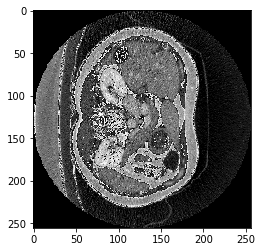

In [256]:
plt.imshow(ima_example, cmap="gray")

In [0]:
def printLayer(layer):
  import random

  print(layer)
  activation_model = keras.models.Model(inputs=model_unet.input, 
                                      outputs=model_unet.get_layer(layer).output)
  array = np.expand_dims(x_test[50], axis=0)
  activations = activation_model.predict(array)
  plt.figure(figsize=(20,3))

  tamaño = activations[0,:, :, :].shape[2]

  if( tamaño > 32 ):
    K = 32
  else:
    K = tamaño

  j = 0

  for i in tqdm(random.choices(range(activations[0,:, :, :].shape[2]), k=K)):
        plt.subplot(2,16,j+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(activations[0,:, :, i], cmap='gray')
        j = j+1

In [293]:
layers = ["conv2d_247","conv2d_248","max_pooling2d_52","conv2d_249","conv2d_250","max_pooling2d_53","conv2d_251","conv2d_252","max_pooling2d_54","conv2d_253","conv2d_254","max_pooling2d_55","conv2d_255","conv2d_256","conv2d_transpose_52","concatenate_52","conv2d_257","conv2d_258","conv2d_transpose_53","concatenate_53","conv2d_259","conv2d_260","conv2d_transpose_54","concatenate_54","conv2d_261","conv2d_262","conv2d_transpose_55","concatenate_55","conv2d_263","conv2d_264","conv2d_265"]

interact(lambda index:printLayer(layers[index]),
         index = widgets.IntSlider(min=0,max=len(layers)-1,
                                   step=1))

interactive(children=(IntSlider(value=0, description='index', max=30), Output()), _dom_classes=('widget-intera…

<function __main__.<lambda>>

## Referencias:

- [Application of Deep Learning to the segmentation of medical images](https://github.com/soribadiaby/Deep-Learning-liver-segmentation-project)
- [U-Net: Convolutional Networks for Biomedical
Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf)
- [Data](https://www.dropbox.com/s/8h2avwtk8cfzl49/ircad-dataset.zip?dl=0)
- [Nibabel library](https://nipy.org/nibabel/)